### Variational autoencoder (VAE)

Variational autoencoder is a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "**Generative Model**".

* An encoder network turns the input samples x into two parameters in a latent space, which we will note **z_mean** and **z_log_sigma**. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via **z = z_mean + exp(z_log_sigma) * epsilon**, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

* The parameters of the model are trained via **two loss functions**: a reconstruction loss forcing the decoded samples to match the initial inputs and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

(KL divergence is a non-symmetric metric that measures the **relative entropy** or difference in information represented by two distributions. It can be thought of as measuring the distance between two data distributions showing how different the two distributions are from each other.)

![](https://www.mdpi.com/make/make-02-00020/article_deploy/html/images/make-02-00020-g001-550.jpg)

Img from: "Ryad Zemouri, Semi-Supervised Adversarial Variational Autoencoder, Cedric-Lab, CNAM, HESAM Université, 292 rue Saint Martin, CEDEX 03, 750141 Paris, France, 6 September 2020"

Variational means, you take the sample from the original input randomly. In standard Autoencoders, we have just a latent vector. Opposite to standard autoencoders, in variational autoencoders, we have the mean and standard deviation of the distribution block that feeds the z block. These terms are updated in the training step.

**Loss function = Reconstruction Loss + KL Divergennce Loss**

Z is the sampled latent vector (run the back propagation through this sampling node)

In [1]:
import keras
import numpy as np
from keras import layers
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import regularizers
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()  # to solve "TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape... problem"

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scaling the data
x_train = (x_train.astype('float32')) / 255.0
x_test = (x_test.astype('float32')) / 255.0

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]

num_channels = 1  # Gray scale

x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

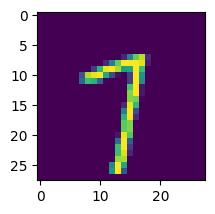

In [4]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

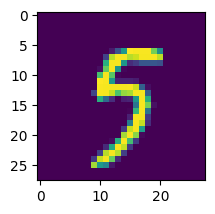

In [5]:
plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

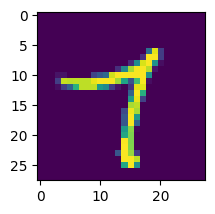

In [6]:
plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

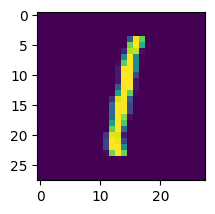

In [7]:
plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])

### Build the model

Encoder

Define 4 Conv2D, flatten and Dense Layers

In [8]:
latent_dim = 2  
''' When the number of digit in the latent dim (number of elements in the representative 
vector) is larger, the output will be more precise, if it is smaller the output image 
will be more blury
'''

input_img = keras.Input(shape=input_shape, name='encoder_input')
x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_img)
x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', strides=(2,2))(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)   # Shape of Convç to be provided to decoder

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)

Two outputs for **latent mean** and **log variance** (standard deviation). Use these to sample random variables in latent space to which inputs are mapped

In [9]:
z_mu = keras.layers.Dense(latent_dim, name='latent_mu')(x)   # Mean values of the encoded input
z_sigma = keras.layers.Dense(latent_dim, name='latent_sigmna')(x)  # Std. dev. (variance) of the encoded input

* Define sampling funtion to sample from the distribution
* Reparameterize sample based on the process defined by Gunderson and Huang into the shape of: 
mean (mu) + sigma squared * eps

This is to allow gradient descent to allow for gradient estimation accurately

In [10]:
'''
* shape: is a property of a tensor object that returns a tuple of integers 
representing the size of the tensor along each dimension. The shape tuple may 
contain None values if the size of a particular dimension is not known at compile time.

* int_shape: is a method of a Keras tensor that returns the shape of the tensor 
as a tuple of integers, with any None dimensions replaced by -1. The -1 indicates
that the size of that dimension is not known at compile time.
'''
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

Sample vector from the latent distribution

z is the lambda custom layer we are adding for gradient descent calculations using mu (mean) and sigma (variance)

In [11]:
z = keras.layers.Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

# Z (lambda layer) will be the last layer of the encoder, define and summarize encoder model
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

Decoder

Decoder takes the latent vector as input

In [12]:
decoder_input = keras.Input(shape=(latent_dim, ), name='decoder_input')

'''
We need to start with a shape that can be remapped to the original image as we 
want our final output to be the same shape original input. So add dense layer
with dimensions that can be reshaped to desired output shape
'''

x = keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)   # conv_shape.shape = (None, 14, 14, 64)
x = keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)  # Reshape to the shape of last conv. layer in the encoder
x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)  # to reverse the conv. layers defined in the encoder
x = keras.layers.Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# defining decoder model
decoder = keras.models.Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [13]:
# Apply the decoder to the latent sample
z_decoded = decoder(z)

### Define custom Loss

VAE is trained using two loss functions: **reconstruction loss** and **KL Divergence loss**


In [14]:
'''
Keras backend mean() func:

x = K.constant([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12]])

# Compute mean along the last axis
mean_x = K.mean(x, axis=-1)

print(mean_x)
# Output: [2.5 6.5 10.5]
'''

'\nKeras backend mean() func:\n\nx = K.constant([[1, 2, 3, 4],\n                [5, 6, 7, 8],\n                [9, 10, 11, 12]])\n\n# Compute mean along the last axis\nmean_x = K.mean(x, axis=-1)\n\nprint(mean_x)\n# Output: [2.5 6.5 10.5]\n'

In [15]:
class CustomLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
    reconstruction_loss = keras.metrics.binary_crossentropy(x, z_decoded)

    # KL Divergence Loss
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [16]:
y = CustomLayer()([input_img, z_decoded])  # apply custom loss to the input images and the decoded latent distribution sample
# y is the original image after encoding input image to mu, sigma, z and decoding sampled z values. It will be used as output
# for VAE

### VAE (Variational Autoencoder)

In [17]:
vae = keras.models.Model(input_img, y, name='vae')

vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

In [18]:
vae.fit(x_train, None, epochs=10, batch_size=32, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47968/48000 [============================>.] - ETA: 0s - loss: 0.2317

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 23s 487us/sample - loss: 0.2316 - val_loss: 0.2091
Epoch 2/10
48000/48000 [==============================] - 12s 247us/sample - loss: 0.2021 - val_loss: 0.1982
Epoch 3/10
48000/48000 [==============================] - 11s 227us/sample - loss: 0.1949 - val_loss: 0.1926
Epoch 4/10
48000/48000 [==============================] - 9s 197us/sample - loss: 0.1913 - val_loss: 0.1898
Epoch 5/10
48000/48000 [==============================] - 10s 205us/sample - loss: 0.1890 - val_loss: 0.1879
Epoch 6/10
48000/48000 [==============================] - 10s 215us/sample - loss: 0.1873 - val_loss: 0.1869
Epoch 7/10
48000/48000 [==============================] - 10s 217us/sample - loss: 0.1861 - val_loss: 0.1858
Epoch 8/10
48000/48000 [==============================] - 9s 186us/sample - loss: 0.1850 - val_loss: 0.1851
Epoch 9/10
48000/48000 [==============================] - 8s 158us/sample - loss: 0.1842 - val_loss: 0.1860
Epoch 10/10
48000/48000 [========

### Visualize results

Visualize inputs mapped to the latent space.

We have encoded inputs to latent space dimension = 2.

Extract z_mu => fist parameter in the result of encoder prediction representing mean

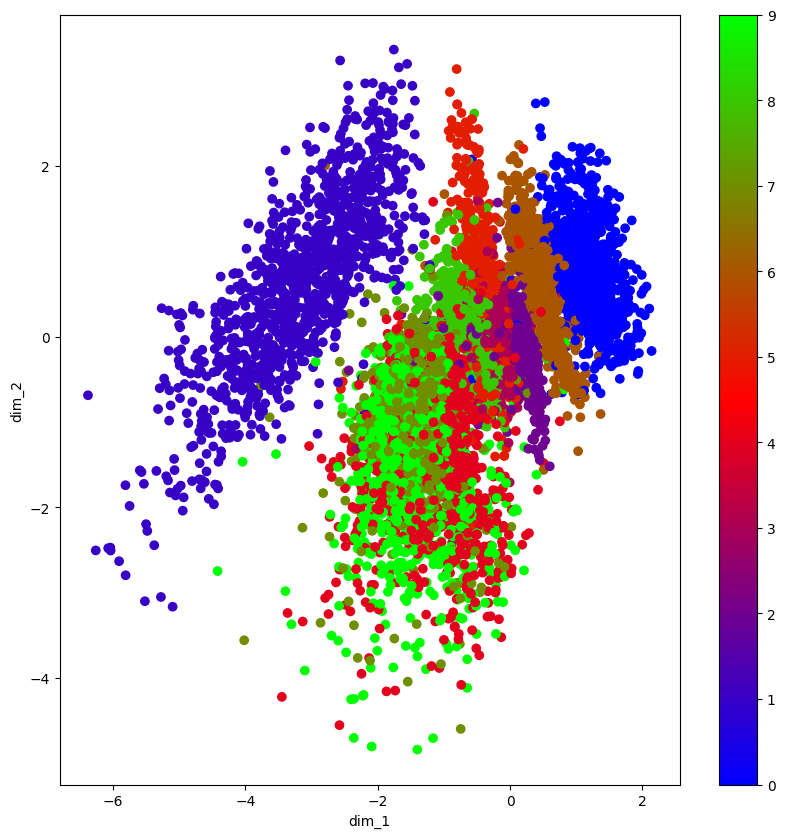

In [27]:
mu, _, _ = encoder.predict(x_test)   # returns z_mu, z_sigma, z

# Plot dim1 and dim2 for mu
plt.figure(figsize=(10,10))
plt.scatter(mu[:,0], mu[:,1], c=y_test, cmap='brg')
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.colorbar()
plt.show()

### Visualize images (Generating Images)

Single decoded image with random input latent vector (of size 1x2)

Latent space range is about -5 to 5 so pick random values within this range. Try starting with -1, 1 and slowly go up to -1.5 to 1.5 and see how it morphs from one image to another


! morph: change smoothly from one image to another by small gradual steps using computer animation techniques.

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


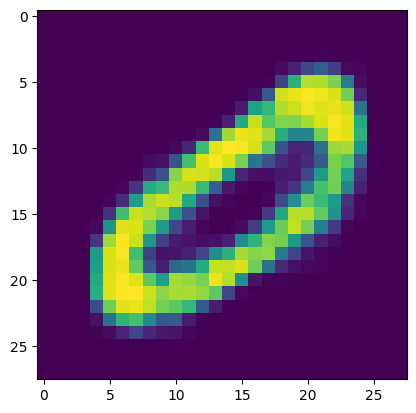

In [25]:
sample_vector = np.array([[1,3]])    # You can track the generated value from above graph, [[2,3]] = 0, [[-4,0]] = 1 ...
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

* Automate this process by generating multiple images and plotting
* Use decoder to generate images by tweaking latent variables from the latent space, 
* Create a grid of defined size with zeros. 
* Take sample from some defined linear space. In this example range [-4, 4]
* Feed it to the decoder and update zeros in the figure with output.


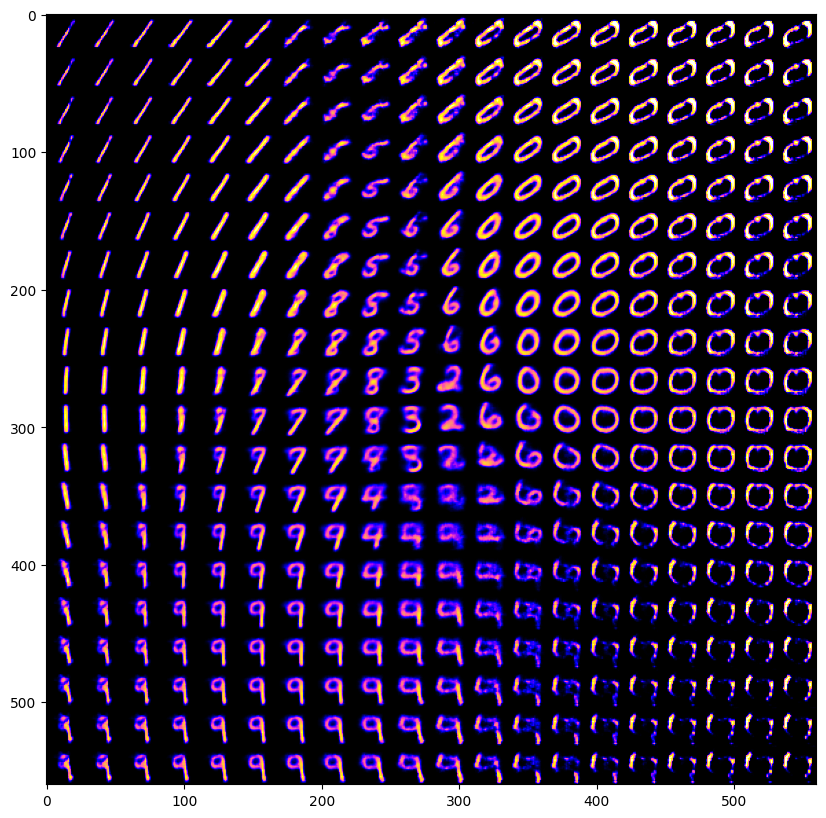

In [28]:
n = 20
figure = np.zeros((img_width * n, img_height * n, num_channels))

# Create a grid of latent variables to be provided as inputs to decoder.predict
# Create vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-4, 4 ,n)
grid_y = np.linspace(-4, 4, n)[::-1]

# Decoder for each square in the grid
for i, yi in enumerate(grid_y):
  for j, xj in enumerate(grid_x):
    z_sample = np.array([[xj, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(img_width, img_height, num_channels)
    figure[i*img_width: (i+1)*img_width, j*img_height: (j+1)*img_height] = digit

plt.figure(figsize=(10,10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()

### Reference

https://www.youtube.com/watch?v=8wrLjnQ7EWQ

https://github.com/bnsreenu/python_for_microscopists

https://github.com/bnsreenu/python_for_microscopists/blob/master/178_179_variational_autoencoders_mnist.py
